# Table of Contents

1. [Custom Plotting Functions](#functions)<br>
2. [Dataset Description](#dataset)<br>
3. [Data Preprocessing](#preprocessing)<br>
4. [Exploratory Data Analysis](#EDA)<br>
5. [Logistic Regression Model](#logreg)<br>
    5a. [Logistic Regression Observations](#logreg_obs)<br>
6. [Support Vector Classifier](#SVC)<br>



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
import os
%matplotlib inline

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import clone

In [164]:
# Linear Classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE

In [2]:
from sklearn.neighbors import KNeighborsClassifier

In [166]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [3]:
# Notebook Styling 
sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))
# pd.set_option('display.float_format',lambda x: '%.5f' % x)
nb_seed = 1234

In [4]:
g_cmap = sns.light_palette('seagreen', n_colors=10, as_cmap=True)
# def confusion_mat_plotter(fitted_clf, X_train_, X_test_, y_train_, y_test_,
#                            class_labels, cmap=g_cmap, ax=None):
#     """
#     Generates plots of the confusion matrices for a classifier's performance
#       with both the training data (to check for overfitting) and the testing data.
#     Args:
#         fitted_clf:   A classifier that has already been fit to training data and labels
#         X_train, ...  Arrays containing the training/testing data/labels."""
#     if ax == None:
#         fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    
#     y_pred_train = fitted_clf.predict(X_train_)
#     y_pred_test = fitted_clf.predict(X_test_)
#     cfn_train = confusion_matrix(y_train_, y_pred_train)
#     cfn_test = confusion_matrix(y_test_, y_pred_test)
    
#     sns.heatmap(cfn_train.T, square=True, annot=True, fmt='d', cbar=True, 
#             xticklabels=class_labels, yticklabels=class_labels, ax=ax[0], cmap=g_cmap,
#                annot_kws={"size": 16})
#     ax[0].set_xlabel('True', fontsize=16)
#     ax[0].set_ylabel('Predicted', fontsize=16)
#     ax[0].set_title('Confusion Matrix (training data)', fontsize=16)
#     sns.heatmap(cfn_test.T, square=True, annot=True, fmt='d', cbar=True, 
#             xticklabels=class_labels, yticklabels=class_labels, ax=ax[1], cmap=g_cmap,
#                annot_kws={"size": 16})
#     ax[1].set_xlabel('True', fontsize=16)
#     ax[1].set_ylabel('Predicted', fontsize=16)
#     ax[1].set_title('Confusion Matrix (testing data)', fontsize=16)
#     for i in range(2):
#         for tick in ax[i].xaxis.get_major_ticks():
#             tick.label.set_fontsize(14) 
#         for tick in ax[i].yaxis.get_major_ticks():
#             tick.label.set_fontsize(14) 
#     plt.tight_layout()

## Custom Functions <a id="functions"></a>

In [5]:
# Setting the color palette for 
g_cmap = sns.light_palette('seagreen', n_colors=10, as_cmap=True)

In [6]:
def cm_plotter(train_cfns_, test_cfns_, labels):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    avg_train_cfn = np.mean(train_cfns_, axis=0)
    avg_test_cfn = np.mean(test_cfns_, axis=0)
    sns.heatmap(avg_train_cfn.T, square=True, annot=True, fmt='0.2f', cbar=True,
                xticklabels=labels, yticklabels=labels, ax=ax[0], cmap=g_cmap,
                annot_kws={"size": 16})
    ax[0].set_xlabel('True', fontsize=16)
    ax[0].set_ylabel('Predicted', fontsize=16)
    ax[0].set_title('Avg Confusion Matrix (training data)', fontsize=16)
    sns.heatmap(avg_test_cfn.T, square=True, annot=True, fmt='0.2f', cbar=True,
                xticklabels=labels, yticklabels=labels, ax=ax[1], cmap=g_cmap,
                annot_kws={"size": 16})
    ax[1].set_xlabel('True', fontsize=16)
    ax[1].set_ylabel('Predicted', fontsize=16)
    ax[1].set_title('Avg Confusion Matrix (testing data)', fontsize=16)
    for i in range(2):
        for tick in ax[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
        for tick in ax[i].yaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
    plt.tight_layout()

    
def cross_validated_cm_generator(clf_, X_train_, y_train_, class_labels, n_splits_=5, n_reps_=6, labels=[0,1]):
    train_cfns = np.zeros((n_splits_*n_reps_,2,2))
    test_cfns = np.zeros((n_splits_*n_reps_,2,2))
    i=0
    
    skfolds = RepeatedStratifiedKFold(n_splits=n_splits_, n_repeats=n_reps_, random_state=nb_seed)
    for train_index, test_index in skfolds.split(X_train_, y_train_):
        X_train_folds = X_train_.iloc[train_index]
        y_train_folds = (y_train_[train_index])
        X_test_folds = X_train_.iloc[test_index]
        y_test_folds = (y_train_[test_index])
        clone_clf = clone(clf_)
        clone_clf.fit(X_train_folds, y_train_folds)
        train_preds = clone_clf.predict(X_train_folds)
        test_preds = clone_clf.predict(X_test_folds)
        train_cfns[i] = confusion_matrix(y_train_folds, train_preds, labels)
        test_cfns[i] = confusion_matrix(y_test_folds, test_preds, labels)
        i += 1
    cm_plotter(train_cfns, test_cfns, labels=class_labels)

In [136]:
#helper
def param_heat_mapper(ax_, df_, ind_col, val_col, col_col, base_clfname, cmap=g_cmap):
    logit_piv = df_.pivot(index=ind_col, values=val_col, columns=col_col)
    title_ = base_clfname + ' Params: ' + ind_col + ' and ' + col_col
    with plt.style.context('seaborn-whitegrid'):
        sns.heatmap(logit_piv, linewidths=0.0, annot=True, fmt='0.3f',
                    ax=ax_, cmap=cmap, robust=True, annot_kws={'size':16})
        ax_.set_title(title_, fontsize=14)
        ax_.set_xlabel('Param: ' + col_col, fontsize=14)
        ax_.set_ylabel('Param: ' + ind_col, fontsize=14)

In [8]:
def train_test_param_map(x_var_, y_var_, map_df_):
    with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(14,6))
        param_heat_mapper(ax[0], map_df_, y_var_, 'mean_train_score', x_var_, '[Training_Data]')
        param_heat_mapper(ax[1], map_df_, y_var_, 'mean_test_score', x_var_, '[Testing_Data]')

# Dataset Description <a id="dataset"></a>

This dataset was collected from the Cleveland Heart Disease Database and consists of 13 features for 270 patients as well as a labeled vector indicating whether specimen has heart disease or not. The 13 features (and their types) are listed and described below.

Features are described here https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4441402/

Attribute Information: 
------------------------ 
1. age 
2. sex 
3. chest pain type (4 values) 
4. resting blood pressure 
5. serum cholestoral in mg/dl 
6. fasting blood sugar > 120 mg/dl 
7. resting electrocardiographic results (values 0,1,2) 
8. maximum heart rate achieved 
9. exercise induced angina 
10. oldpeak = ST depression induced by exercise relative to rest 
11. the slope of the peak exercise ST segment 
12. number of major vessels (0-3) colored by flourosopy 
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 

Attributes types 
----------------- 

* Real: 1,4,5,8,10,12 
* Ordered:11, 
* Binary: 2,6,9 
* Nominal:7,3,13 

In [9]:
CSV_PATH = os.path.join('data', 'heart_disease', 'train_values.csv')
X_train = pd.read_csv(CSV_PATH, encoding='latin1', index_col='patient_id') 
X_train.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.00000,1,45,170,0
ryoo3j,2,normal,110,3,0,0,0,214,1.60000,0,54,158,0
yt1s1x,1,normal,125,4,3,0,2,304,0.00000,1,77,162,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.00000,1,40,181,0
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.20000,1,59,145,0


In [10]:
CSV_PATH = os.path.join('data', 'heart_disease', 'test_values.csv')
X_test = pd.read_csv(CSV_PATH, encoding='latin1', index_col='patient_id') 
X_test.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
olalu7,2,reversible_defect,170,1,0,0,2,288,0.20000,1,59,159,0
z9n6mx,1,normal,138,4,0,0,0,183,1.40000,0,35,182,0
5k4413,2,reversible_defect,120,4,0,0,2,177,2.50000,1,43,120,1
mrg7q5,1,normal,102,3,1,0,0,318,0.00000,0,60,160,0
uki4do,2,normal,138,4,1,0,2,166,3.60000,1,61,125,1


In [11]:
CSV_PATH = os.path.join('data', 'heart_disease', 'train_labels.csv')
y_train = pd.read_csv(CSV_PATH, encoding='latin1', index_col='patient_id') 
y_train.head()

,heart_disease_present
patient_id,
0z64un,0
ryoo3j,0
yt1s1x,1
l2xjde,1
oyt4ek,0


**From the info printout below, we see that all of the features except for 'thal' (Thalium heart scan observation), which is has the object (string) type. From the given feature information, we know that the [sex, fasting_blood_sugar_gt_120_mg_per_dl, exercise_induced_angina] features are binary categories and [resting_ekg_results, chest_pain_type, thal, slope_of_peak_exercise_st_segment] categorical features with more than 2 categories.** 

**I'm using sklearn's machine learning libraries for my analysis, and sklearn is built on the numpy library which cannot correctly handle features of categorical data. To produce correct results, we'll have to make dummy variables for categorical features.**

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       180 non-null int64
thal                                    180 non-null object
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null int64
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null int64
resting_ekg_results                     180 non-null int64
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null int64
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 19.7+ KB


## Data Preprocessing <a id="preprocessing"></a>

In [13]:
categoricals = ['chest_pain_type', 'resting_ekg_results', 'thal', 
                'sex', 'fasting_blood_sugar_gt_120_mg_per_dl', 
                'exercise_induced_angina', 'slope_of_peak_exercise_st_segment']

def categorize_features(df, cats):
    df_cols = df.columns.tolist()
    for cat in cats:
        if cat in df_cols:
            df[cat] = df[cat].astype('category')
    return df

In [14]:
X_train = categorize_features(X_train, categoricals)
X_test = categorize_features(X_test, categoricals)

In [ ]:
# converting the type of categorical features
# X_train['chest_pain_type'] = X_train['chest_pain_type'].astype('category')
# X_train['resting_ekg_results'] = X_train['resting_ekg_results'].astype('category')
# X_train['thal'] = X_train['thal'].astype('category')
# X_train['sex'] = X_train['sex'].astype('category')
# X_train['fasting_blood_sugar_gt_120_mg_per_dl'] = X_train['fasting_blood_sugar_gt_120_mg_per_dl'].astype('category')
# X_train['exercise_induced_angina'] = X_train['exercise_induced_angina'].astype('category')
# X_train['slope_of_peak_exercise_st_segment'] = X_train['slope_of_peak_exercise_st_segment'].astype('category')

### Nominal Categorical Types 

In [15]:
# 1: typical angina, 
# 2: atypical angina, 
# 3: non-angina, 
# 4: asymptotic angina
X_train['chest_pain_type'].unique()

[2, 3, 4, 1]
Categories (4, int64): [2, 3, 4, 1]

In [16]:
# Resting electrocardiographic results
# 0: normal, 
# 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 
# 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria;
X_train['resting_ekg_results'].unique()

[2, 0, 1]
Categories (3, int64): [2, 0, 1]

In [17]:
# Thalium heart scan
X_train['thal'].unique()

[normal, reversible_defect, fixed_defect]
Categories (3, object): [normal, reversible_defect, fixed_defect]

In [18]:
# 1: upsloping
# 2: flat
# 3: downsloping
X_train['slope_of_peak_exercise_st_segment'].unique()

[1, 2, 3]
Categories (3, int64): [1, 2, 3]

### Binary Categorical Types

In [19]:
# 0: Female, 1: Male
X_train['sex'].unique()

[1, 0]
Categories (2, int64): [1, 0]

In [20]:
# 0: False, 1: True
X_train['fasting_blood_sugar_gt_120_mg_per_dl'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [21]:
# 0: False, 1: True
X_train['exercise_induced_angina'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       180 non-null category
thal                                    180 non-null category
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null category
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null category
resting_ekg_results                     180 non-null category
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null category
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null category
dtypes: category(7), float64(1), int64(5)
memory usage: 11.8+ KB


**After changing the data types of the categorical features, we see that the memory usage dropped from 19.7 KB to 11.8 KB. While this is an extremely small dataset, on larger datasets this would produce a substantial improvement in runtime.**

## Exploratory Data Analysis <a id="EDA"></a>
Before creating dummy variables (and increasing the number of features), we should examine the data.

In [23]:
# Joining the labeled output with the features, for plotting
train_df = y_train.join(X_train)

In [24]:
train_df.head()

,heart_disease_present,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,,
0z64un,0,1,normal,128,2,0,0,2,308,0.00000,1,45,170,0
ryoo3j,0,2,normal,110,3,0,0,0,214,1.60000,0,54,158,0
yt1s1x,1,1,normal,125,4,3,0,2,304,0.00000,1,77,162,1
l2xjde,1,1,reversible_defect,152,4,0,0,0,223,0.00000,1,40,181,0
oyt4ek,0,3,reversible_defect,178,1,0,0,2,270,4.20000,1,59,145,0


**As we'll be plotting some categorical features, I'll set an appropriate palette.**

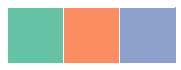

In [25]:
colors = ['#66c2a5', '#fc8d62', '#8da0cb']
cat_palette = sns.color_palette(['#66c2a5', '#fc8d62', '#8da0cb'])
sns.palplot(cat_palette)

**From the frequency plot of heart disease below, we see that the two classes ('Heart Disease' and 'No Heart Disease') are approximately balanced, with 45% of observations having heart disease and the remaining population not having heart disease. **

(0, 105)

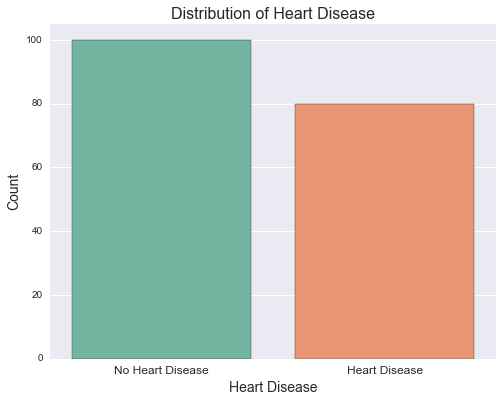

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=train_df, x='heart_disease_present', palette=cat_palette, ax=ax)
ax.set_title('Distribution of Heart Disease', fontsize=16)
ax.set_xlabel('Heart Disease', fontsize=14)
ax.set_xticklabels(['No Heart Disease', 'Heart Disease'], fontsize=12)
ax.set_ylabel('Count', fontsize=14)
ax.set_ylim([0,105])

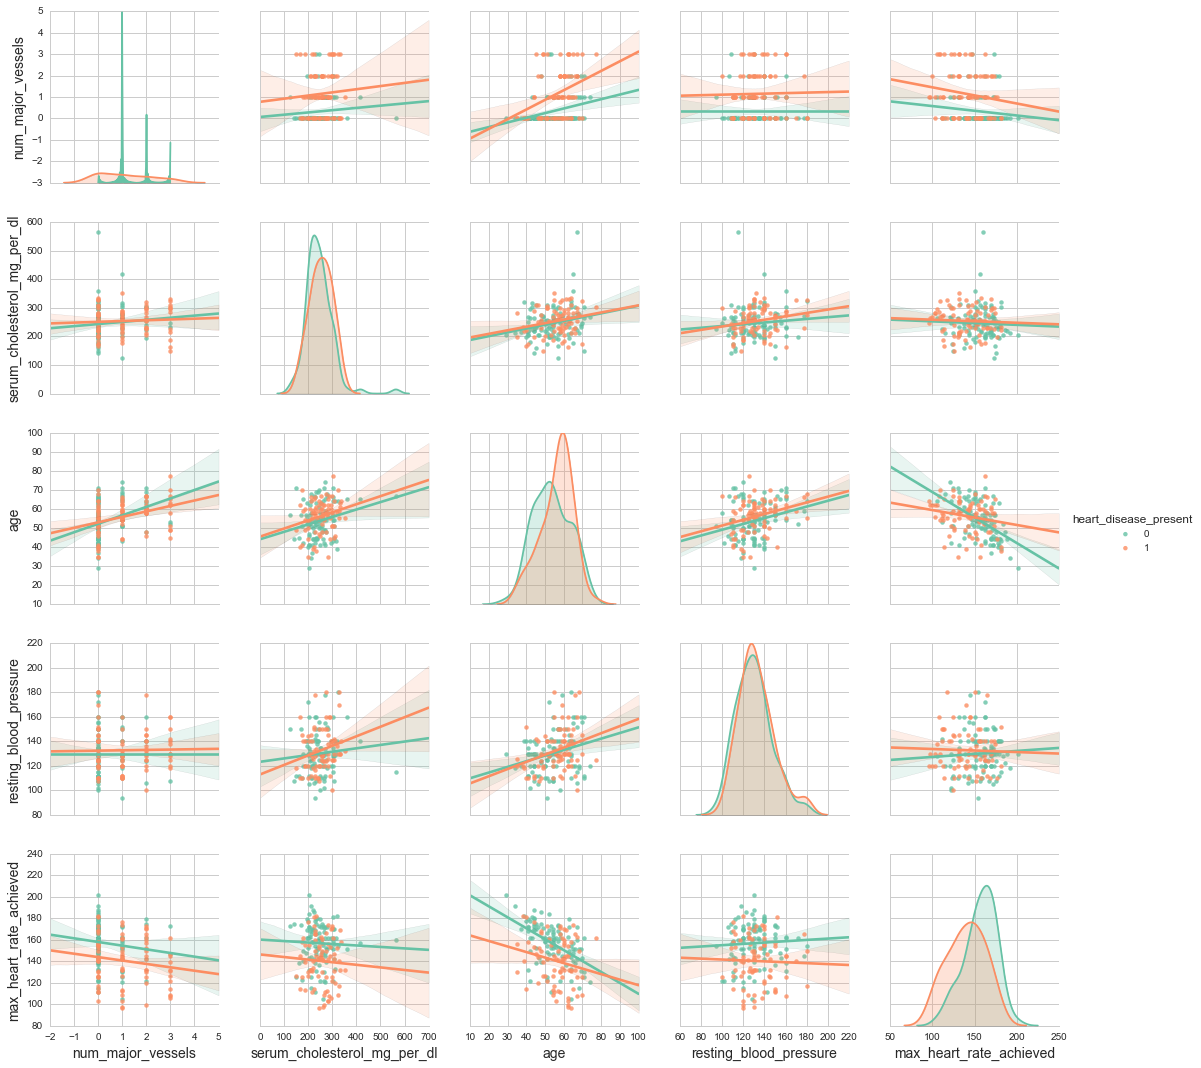

In [27]:
with sns.axes_style("whitegrid"):
    plt.rcParams["axes.labelsize"] = 14
    sns.pairplot(train_df, 
                 vars=['num_major_vessels', 'serum_cholesterol_mg_per_dl', 'age', 
                       'resting_blood_pressure', 'max_heart_rate_achieved'], 
                 kind='reg',
                 diag_kind='kde',
                 hue='heart_disease_present',
                 diag_kws={'shade':True},
                 palette=cat_palette, 
                 size=3)

**I've plotted all of the numerical features in the pairplot above, and I've colored the data by the 'heart_disease_present' label. The off-diagonal scatter plots include regression lines to show the trends for both populations relative to that plot's features, and the diagonal shows kernel density plots showing the rough distributions of the two populations.**

We can make a couple observations:
* From the plot of resting blood pressure as a function of age, we see that resting blood pressure tends to increase with age regardless of heart disease.
* From the plot of max heart rate as a function of age, we see that max heart rates are significantly lower for people without heart disease. 

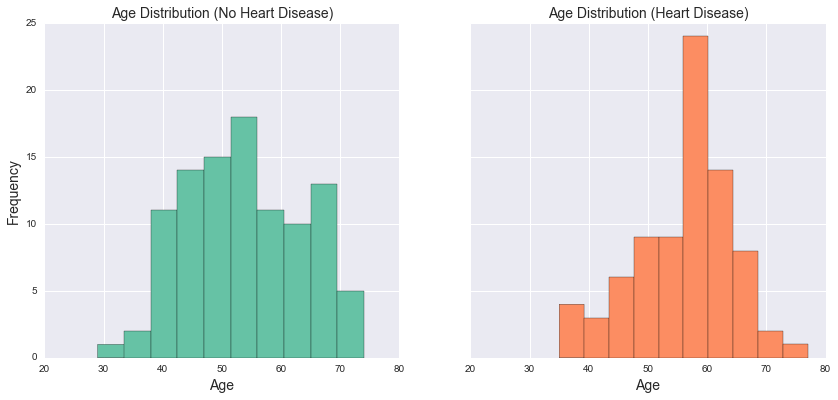

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(14,6))
train_df[train_df['heart_disease_present']==0]['age'].plot(kind='hist', color=colors[0], ax=ax[0])
train_df[train_df['heart_disease_present']==1]['age'].plot(kind='hist', color=colors[1], ax=ax[1])
ax[0].set_xlabel('Age', fontsize=14)
ax[1].set_xlabel('Age', fontsize=14)
ax[0].set_title('Age Distribution (No Heart Disease)', fontsize=14)
ax[1].set_title('Age Distribution (Heart Disease)', fontsize=14)

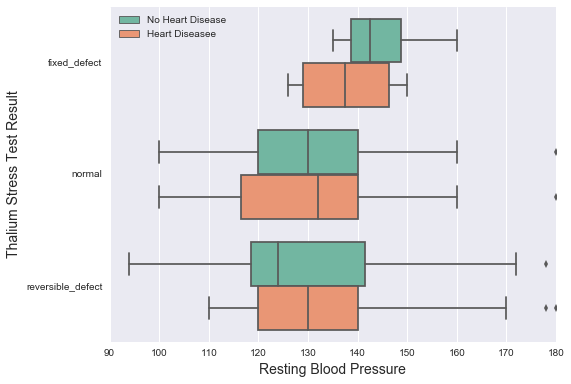

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=train_df, 
            y='thal', 
            x='resting_blood_pressure', 
            hue='heart_disease_present', 
            palette=cat_palette,
            ax=ax)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['No Heart Disease','Heart Diseasee'], loc='best', )
ax.set_xlabel('Resting Blood Pressure', fontsize=14)
ax.set_ylabel('Thalium Stress Test Result', fontsize=14)

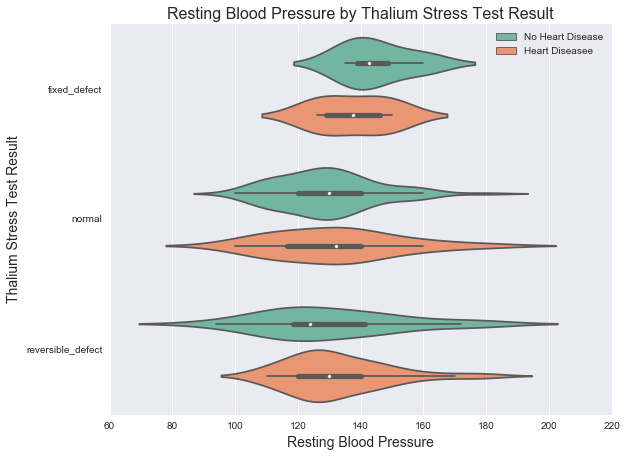

In [30]:
fig, ax = plt.subplots(figsize=(9,7))
sns.violinplot(data=train_df, 
            y='thal', 
            x='resting_blood_pressure', 
            hue='heart_disease_present',
            palette=cat_palette,
            ax=ax)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['No Heart Disease','Heart Diseasee'], loc='best', )
ax.set_xlabel('Resting Blood Pressure', fontsize=14)
ax.set_ylabel('Thalium Stress Test Result', fontsize=14)
ax.set_title('Resting Blood Pressure by Thalium Stress Test Result', fontsize=16)

In [86]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 14 columns):
heart_disease_present                   180 non-null int64
slope_of_peak_exercise_st_segment       180 non-null category
thal                                    180 non-null category
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null category
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null category
resting_ekg_results                     180 non-null category
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null category
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null category
dtypes: category(7), float64(1), int64(6)
m

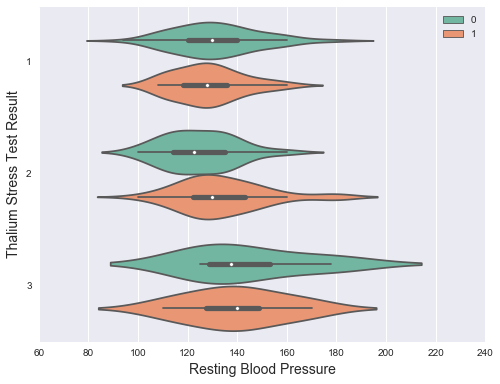

In [88]:
fig, ax = plt.subplots(figsize=(8,6))
sns.violinplot(data=train_df, 
            y='slope_of_peak_exercise_st_segment', 
            x='resting_blood_pressure', 
            hue='heart_disease_present',
            palette=cat_palette,
            ax=ax)
ax.set_xlabel('Resting Blood Pressure', fontsize=14)
ax.set_ylabel('Thalium Stress Test Result', fontsize=14)
ax.legend(loc='best')

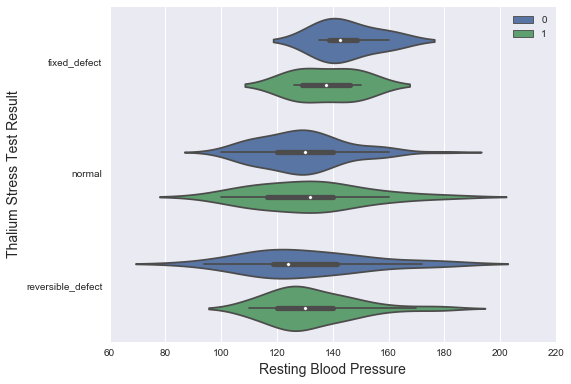

In [158]:
fig, ax = plt.subplots(figsize=(8,6))
sns.violinplot(data=train_df, 
            y='thal', 
            x='resting_blood_pressure', 
            hue='heart_disease_present',  
            ax=ax)
ax.set_xlabel('Resting Blood Pressure', fontsize=14)
ax.set_ylabel('Thalium Stress Test Result', fontsize=14)
ax.legend(loc='best')

In [26]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Models <a id="models"></a>

## Logistic Regression <a id="logreg"></a>

In [137]:
logreg = LogisticRegression()
parameters = {'penalty':['l1','l2'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
logreg_gs = GridSearchCV(logreg, parameters, cv=10, return_train_score=True)
logreg_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

print("Best CV params", logreg_gs.best_params_)
best_lr = logreg_gs.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print('Number of selected features: {}'.format(np.count_nonzero(coefs)))

Best CV params {'C': 0.1, 'penalty': 'l2'}
Total number of features: 18
Number of selected features: 18


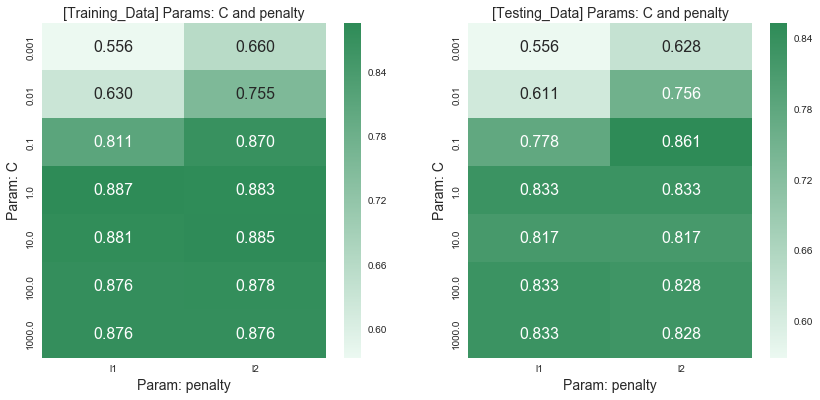

In [138]:
grid_clf = logreg_gs
logreg_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                    'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                    'C': grid_clf.cv_results_['param_C'], 
                    'penalty': grid_clf.cv_results_['param_penalty']} 

train_test_param_map(x_var_='penalty', y_var_='C', map_df_=pd.DataFrame(logreg_grid_dict))

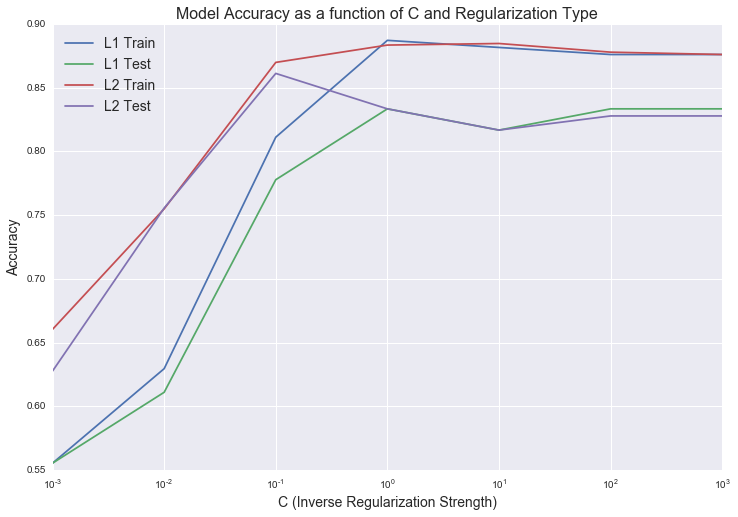

In [139]:
map_df = pd.DataFrame(logreg_grid_dict)
x_var = map_df[map_df['penalty'] == 'l1']['C']

fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_train_score'], label='L1 Train')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_test_score'], label='L1 Test')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_train_score'], label='L2 Train')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_test_score'], label='L2 Test')
ax.legend(fontsize=14, loc='best')
ax.set_title('Model Accuracy as a function of C and Regularization Type', fontsize=16)
ax.set_xlabel('C (Inverse Regularization Strength)', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

In [140]:
print('Best accuracy: {:0.3f}%'.format(logreg_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(logreg_gs.best_params_))

Best accuracy: 86.111%
Best parameter(s): {'C': 0.1, 'penalty': 'l2'}


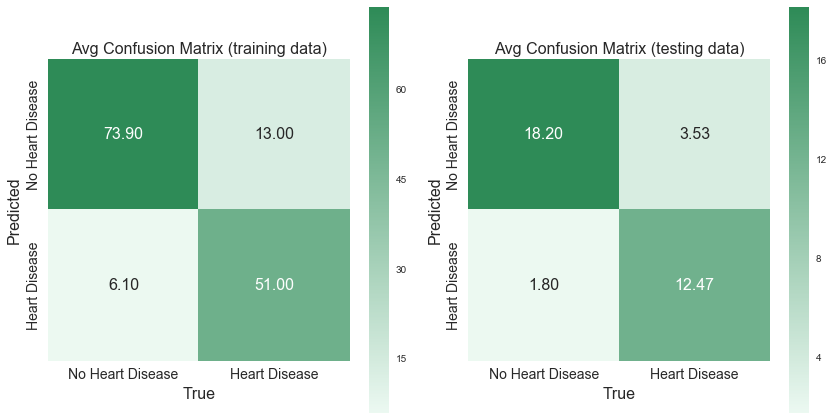

In [141]:
cross_validated_cm_generator(clf_=logreg_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

### Logistic Regression Observations <a id="logreg_obs"></a>
From the plot and printout above, we see that the highest accuracy is achieved when the parameter $C$ is set to $0.1$ and the penalty parameter is set to 'l2' (aka **Ridge Regression**). However, accuracy is a measure of how well **all** cases were classified, and the 2 different kinds of misclassifications (labeling a healthy person as unhealthy, and labeling an unhealthy person as healthy) are not equally bad. It's definitely worse to label someone as healthy if they actually have heart disease, as their heart disease would go untreated, and they may continue with an unhealthy diet or pursue dangerous activity levels. In terms of classification metrics, that kind of prediction mistake is a **False Negative**. The alternative mistake (a **False Positive**) is to label someone as unhealthy when they are actually healthy, which would lead to someone unnecessarily changing their diet and lifestyle, which would be unpleasant, but not potentially lethal, as in the other case. From the **confusion matrices** above, we see that the most 'accurate' model tends to make the worse kind of mistake.

We should try to build a model again, but we should use a scoring metric that takes the cost of mistakes into account. 

In [142]:
logreg = LogisticRegression()
parameters = {'penalty':['l1','l2'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
logreg_gs = GridSearchCV(logreg, parameters, cv=10, return_train_score=True, scoring='recall')
logreg_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

print("Best CV params", logreg_gs.best_params_)
best_lr = logreg_gs.best_estimator_
coefs = best_lr.coef_
print('Total number of features: {}'.format(coefs.size))
print('Number of selected features: {}'.format(np.count_nonzero(coefs)))
print('Average Accuracy of the best model: {}'.format(logreg_gs.best_score_))

Best CV params {'C': 1, 'penalty': 'l1'}
Total number of features: 18
Number of selected features: 13
Average Accuracy of the best model: 0.825


This time, the number of significant features is less than the total number of features, so I'll recursively eliminate unimportant features.

In [143]:
logreg = LogisticRegression(C=1, penalty='l1')
logreg_rfe = RFE(logreg, 13)
logreg_rfe.fit(X_train, y_train.values.reshape((len(y_train), )))
print(logreg_rfe.support_)
print(logreg_rfe.ranking_)

[ True  True  True  True  True  True  True False  True  True False False
  True False False  True  True  True]
[1 1 1 1 1 1 1 4 1 1 3 2 1 5 6 1 1 1]


In [144]:
X_train.loc[:,logreg_rfe.support_].columns.tolist()

['resting_blood_pressure',
 'num_major_vessels',
 'serum_cholesterol_mg_per_dl',
 'oldpeak_eq_st_depression',
 'age',
 'max_heart_rate_achieved',
 'slope_of_peak_exercise_st_segment_2',
 'thal_normal',
 'thal_reversible_defect',
 'chest_pain_type_4',
 'resting_ekg_results_2',
 'sex_1',
 'exercise_induced_angina_1']

In [145]:
logreg = LogisticRegression()
parameters = {'penalty':['l1','l2'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
logreg_gs = GridSearchCV(logreg, parameters, cv=10, return_train_score=True, scoring='recall')
logreg_gs.fit(X_train.loc[:,logreg_rfe.support_], y_train.values.reshape((y_train.size,)))

print("Best CV params", logreg_gs.best_params_)
best_lr = logreg_gs.best_estimator_
coefs = best_lr.coef_
print('Total number of features: {}'.format(coefs.size))
print('Number of selected features: {}'.format(np.count_nonzero(coefs)))
print('Average Accuracy of the best model: {}'.format(logreg_gs.best_score_))

Best CV params {'C': 1, 'penalty': 'l1'}
Total number of features: 13
Number of selected features: 13
Average Accuracy of the best model: 0.825


Ok, so we can see that the l1 logistic regression (aka **Lasso Regression**) was smart enough to assign 0 importance to features below the significance threshold.  

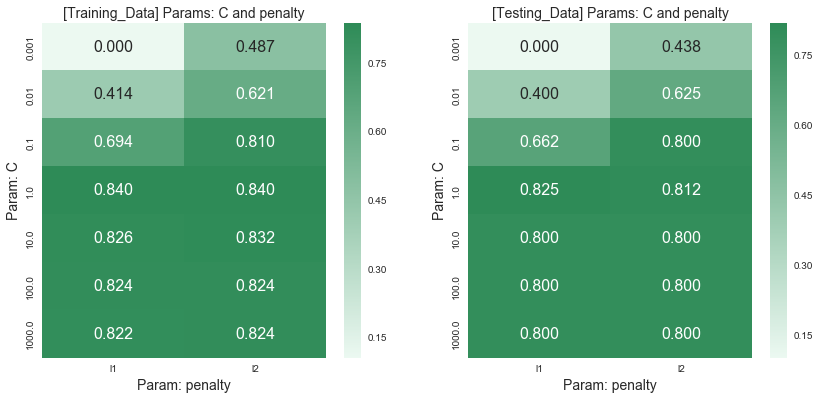

In [146]:
grid_clf = logreg_gs
logreg_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                    'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                    'C': grid_clf.cv_results_['param_C'], 
                    'penalty': grid_clf.cv_results_['param_penalty']} 

train_test_param_map(x_var_='penalty', y_var_='C', map_df_=pd.DataFrame(logreg_grid_dict))

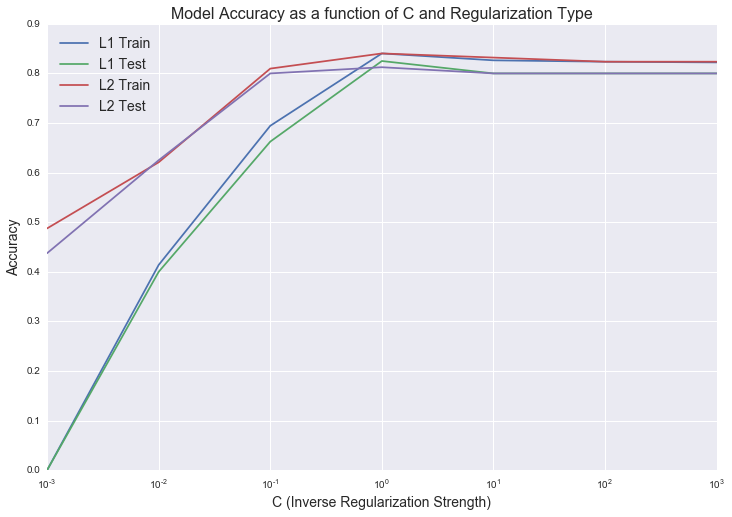

In [147]:
map_df = pd.DataFrame(logreg_grid_dict)
x_var = map_df[map_df['penalty'] == 'l1']['C']

fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_train_score'], label='L1 Train')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_test_score'], label='L1 Test')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_train_score'], label='L2 Train')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_test_score'], label='L2 Test')
ax.legend(fontsize=14, loc='best')
ax.set_title('Model Accuracy as a function of C and Regularization Type', fontsize=16)
ax.set_xlabel('C (Inverse Regularization Strength)', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

In [148]:
print('Best accuracy: {:0.3f}%'.format(logreg_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(logreg_gs.best_params_))

Best accuracy: 82.500%
Best parameter(s): {'C': 1, 'penalty': 'l1'}


The confusion matrices directly below as well as the confusion matrices a bit further up were made by fitting classifiers with 30 different slices of the data and generating a confusion matrix for each data slice. The confusion matrices below used a classifier with parameters {$C = 1$, penalty $= \text{L1}$}, only used the 13 features that the recursive feature elimination found to be significant, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.27$ unhealthy people as being healthy, which is slightly better than the above model, which labeled $3.53$ unhealthy people as healthy, but this model labeled $2.63$ healthy people as unhealthy while the above model labeled $1.80$ healthy people as unhealthy.

Considering the differing costs of mistakes, I'd say this is an improvement.

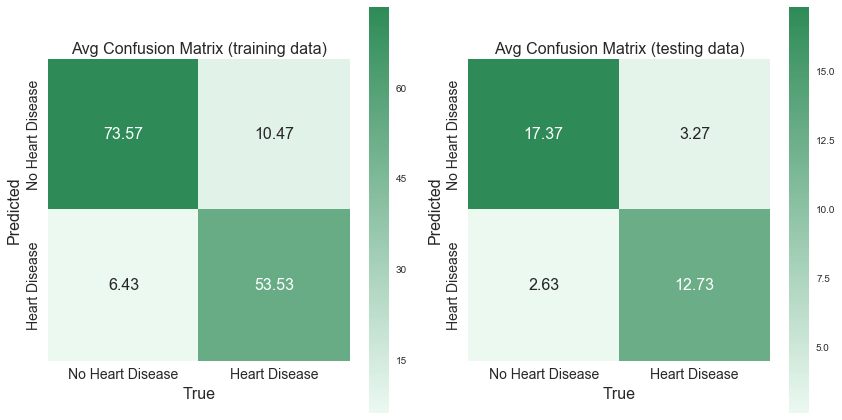

In [149]:
cross_validated_cm_generator(clf_=logreg_gs.best_estimator_, 
                             X_train_=X_train.loc[:,logreg_rfe.support_],
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

### Normalizing Feature Values (Pipeline Example)

In the previous models, I didn't normalize the data to a consistent scale. This means features that had a very small unit size may have a high nominal value, which can mislead some learning algorithms into overestimating the significance of that feature. In this model, I'll try scaling the features and I'll revert to using the full set of training features. 

In [150]:
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]
pipeline = Pipeline(steps)
parameters = {'logreg__penalty':['l1','l2'],
              'logreg__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
logreg_gs = GridSearchCV(pipeline, parameters, cv=10, return_train_score=True, scoring='recall')
logreg_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

print("Best CV params", logreg_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(logreg_gs.best_score_))

Best CV params {'logreg__C': 0.0001, 'logreg__penalty': 'l2'}
Average Accuracy of the best model: 0.825


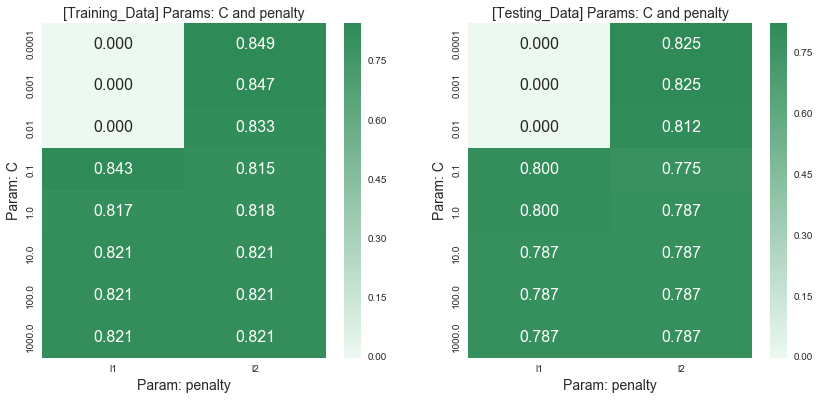

In [151]:
grid_clf = logreg_gs
logreg_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                    'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                    'C': grid_clf.cv_results_['param_logreg__C'], 
                    'penalty': grid_clf.cv_results_['param_logreg__penalty']} 

train_test_param_map(x_var_='penalty', y_var_='C', map_df_=pd.DataFrame(logreg_grid_dict))

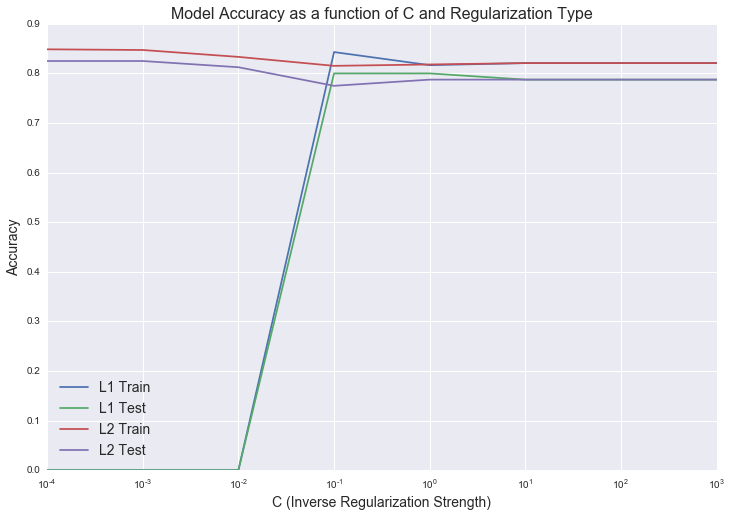

In [152]:
map_df = pd.DataFrame(logreg_grid_dict)
x_var = map_df[map_df['penalty'] == 'l1']['C']

fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_train_score'], label='L1 Train')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_test_score'], label='L1 Test')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_train_score'], label='L2 Train')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_test_score'], label='L2 Test')
ax.legend(fontsize=14, loc='best')
ax.set_title('Model Accuracy as a function of C and Regularization Type', fontsize=16)
ax.set_xlabel('C (Inverse Regularization Strength)', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

In [153]:
print('Best accuracy: {:0.3f}%'.format(logreg_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(logreg_gs.best_params_))

Best accuracy: 82.500%
Best parameter(s): {'logreg__C': 0.0001, 'logreg__penalty': 'l2'}


The confusion matrices below used a classifier with parameters {$C = 0.0001$, penalty $= \text{L2}$}, used normalized data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $2.70$ unhealthy people as being healthy, which is slightly better than both of the above models, which labeled $3.53$ and $3.27$ unhealthy people as healthy, but this model labeled $3.60$ healthy people as unhealthy which is more than both of the previous models.

Considering the differing costs of mistakes, I'd say this is yet another improvement.

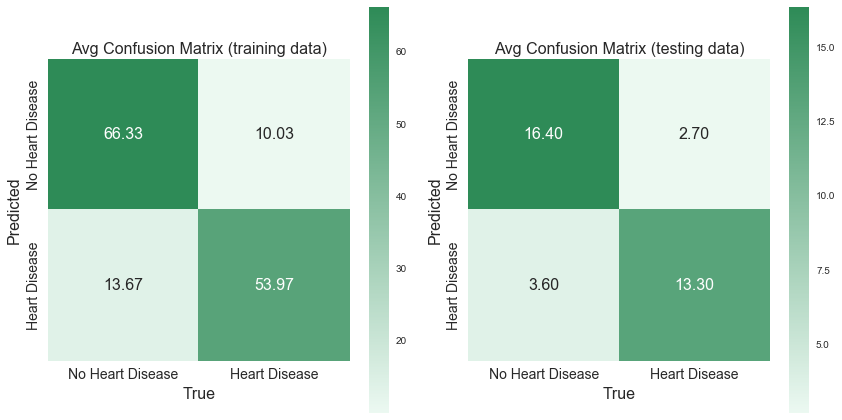

In [154]:
cross_validated_cm_generator(clf_=logreg_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

## Support Vector Classifiers <a id="SVC"></a>

Support Vector classifiers are another linear classifier (ie another classifier which uses a linear combination of feature weights), except SVCs are able to produce a much more sophisticated decision boundary. This time, I'll start off using a pipeline and normalizing features.

In [155]:
steps = [('scaler', StandardScaler()),
         ('svm', SVC())]
pipeline = Pipeline(steps)
parameters = [{'svm__kernel':['rbf', 'poly', 'sigmoid'],
               'svm__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
               'svm__gamma':[0.001, 0.005, 0.01, 0.05, 0.1]}]
svm_gs = GridSearchCV(pipeline, parameters, cv=10, return_train_score=True, scoring='recall')
svm_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

print("Best CV params", svm_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(svm_gs.best_score_))

Best CV params {'svm__C': 1, 'svm__gamma': 0.005, 'svm__kernel': 'rbf'}
Average Accuracy of the best model: 0.8125


From the printout, we can see that the best model uses the 'rbf' kernel (Radial Basis Function) and hyperparamaters $C = 1.0$ and $\gamma \text{ (gamma)} = 0.005$ 

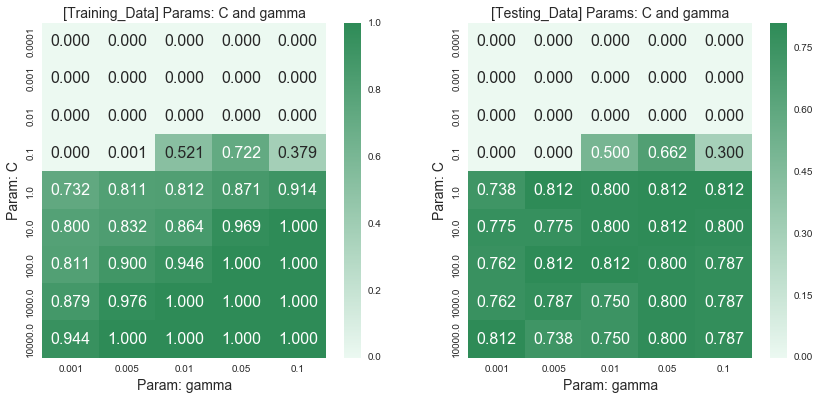

In [156]:
grid_clf = svm_gs
svm_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                    'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                    'kernel': grid_clf.cv_results_['param_svm__kernel'],
                    'C': grid_clf.cv_results_['param_svm__C'], 
                    'gamma': grid_clf.cv_results_['param_svm__gamma']} 

map_df = pd.DataFrame(svm_grid_dict)
train_test_param_map(x_var_='gamma', y_var_='C', map_df_=map_df[map_df['kernel'] == 'rbf'])

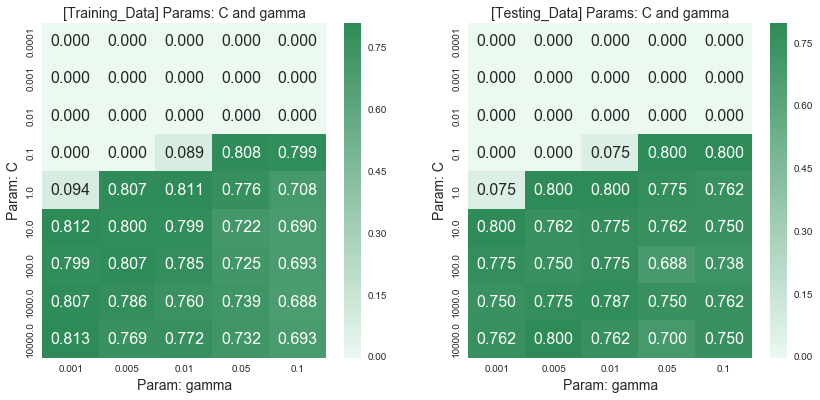

In [157]:
# Sigmoid SVC results
train_test_param_map(x_var_='gamma', y_var_='C', map_df_=map_df[map_df['kernel'] == 'sigmoid'])

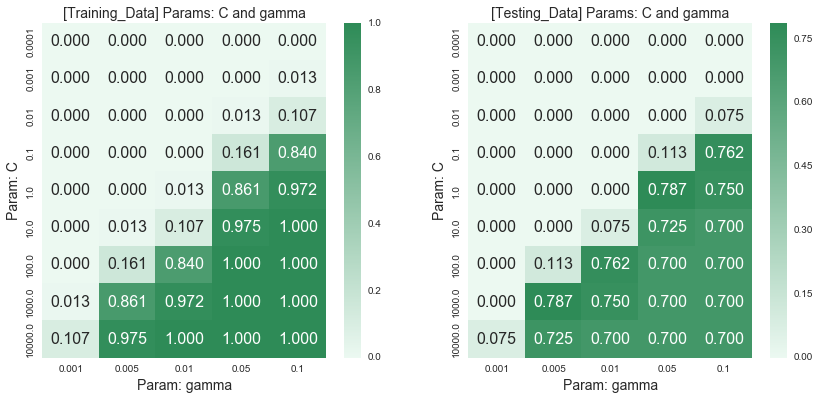

In [158]:
# Polynomial SVC results
train_test_param_map(x_var_='gamma', y_var_='C', map_df_=map_df[map_df['kernel'] == 'poly'])

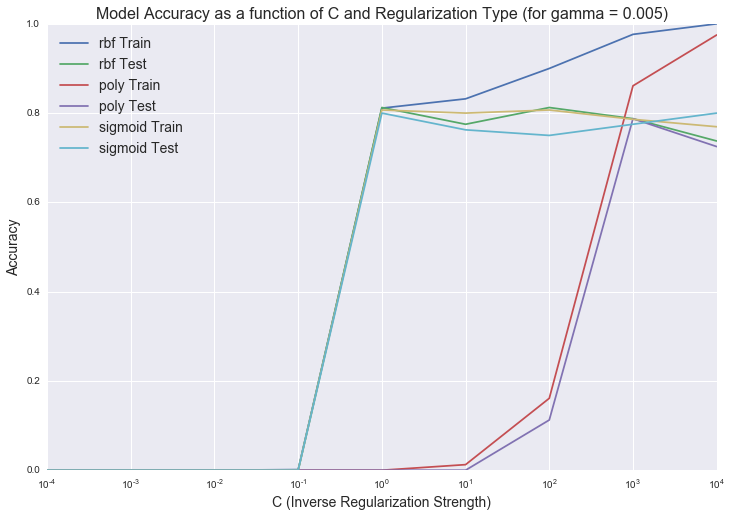

In [159]:
x_var = map_df[map_df['kernel'] == 'rbf']
x_var = x_var[x_var['gamma'] == 0.005]['C']
rbf = map_df[map_df['kernel'] == 'rbf']
rbf = rbf[rbf['gamma'] == 0.005]
poly = map_df[map_df['kernel'] == 'poly']
poly = poly[poly['gamma'] == 0.005]
sigmoid = map_df[map_df['kernel'] == 'sigmoid']
sigmoid = sigmoid[sigmoid['gamma'] == 0.005]

fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(x_var, rbf['mean_train_score'], label='rbf Train')
ax.semilogx(x_var, rbf['mean_test_score'], label='rbf Test')
ax.semilogx(x_var, poly['mean_train_score'], label='poly Train')
ax.semilogx(x_var, poly['mean_test_score'], label='poly Test')
ax.semilogx(x_var, sigmoid['mean_train_score'], label='sigmoid Train')
ax.semilogx(x_var, sigmoid['mean_test_score'], label='sigmoid Test')
ax.legend(fontsize=14, loc='best')
ax.set_title('Model Accuracy as a function of C and Regularization Type (for gamma = 0.005)', fontsize=16)
ax.set_xlabel('C (Inverse Regularization Strength)', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

In [160]:
print('Best accuracy: {:0.3f}%'.format(svm_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(svm_gs.best_params_))

Best accuracy: 81.250%
Best parameter(s): {'svm__C': 1, 'svm__gamma': 0.005, 'svm__kernel': 'rbf'}


The confusion matrices below used a **Support Vector Classifier** with parameters {$C = 1.0$, kernel $= \text{rbf}$, and $\gamma = 0.005$}, used normalized data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.17$ unhealthy people as being healthy, which is slightly worse than the best logistic regression classifier above, although this model labeled $2.93$ healthy people as unhealthy which is slightly better than the best logistic regression model.

Considering the differing costs of mistakes, this is a not an improvement on our best model.

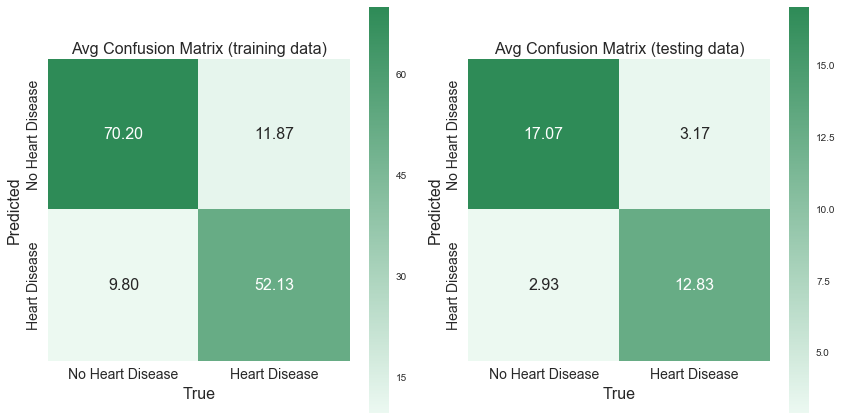

In [162]:
cross_validated_cm_generator(clf_=svm_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

## Decision Tree Classifier

In [168]:
steps = [('dt', DecisionTreeClassifier())]
pipeline = Pipeline(steps)
parameters = [{'dt__criterion':['entropy', 'gini'],
               'dt__max_depth':[2,5,10,20], 
               'dt__min_samples_leaf':[1,2,3,4,5], 
               'dt__random_state':[nb_seed]}]
dt_gs = GridSearchCV(pipeline, parameters, cv=10, return_train_score=True, scoring='recall', n_jobs=-1, verbose=9)
dt_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'dt__criterion': ['entropy', 'gini'], 'dt__max_depth': [2, 5, 10, 20], 'dt__min_samples_leaf': [1, 2, 3, 4, 5], 'dt__random_state': [1234]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=9)

In [169]:
print("Best CV params", dt_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(dt_gs.best_score_))

Best CV params {'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__min_samples_leaf': 3, 'dt__random_state': 1234}
Average Accuracy of the best model: 0.7375


From the printout, we can see that the best model uses the 'gini' information criterion to determine when to split, a max depth of 10 nodes, and at least 3 samples for any leaf.

In [170]:
grid_clf = dt_gs
dt_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                'criterion': grid_clf.cv_results_['param_dt__criterion'],
                'max_depth': grid_clf.cv_results_['param_dt__max_depth'], 
                'min_samples_leaf': grid_clf.cv_results_['param_dt__min_samples_leaf']} 

map_df = pd.DataFrame(dt_grid_dict)

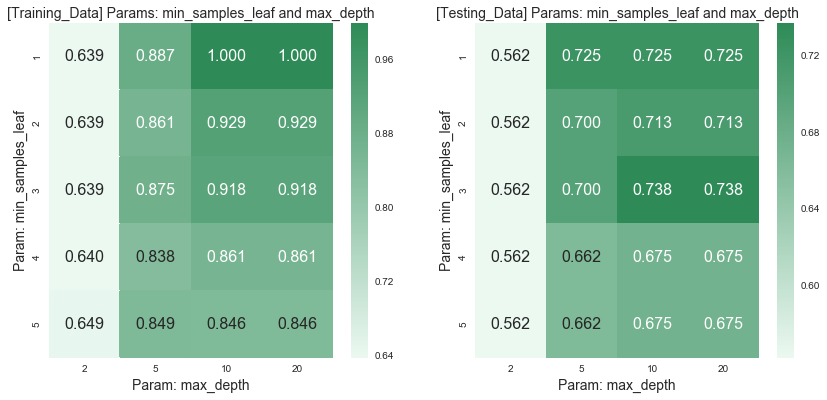

In [171]:
train_test_param_map(x_var_='max_depth', y_var_='min_samples_leaf', map_df_=map_df[map_df['criterion'] == 'gini'])

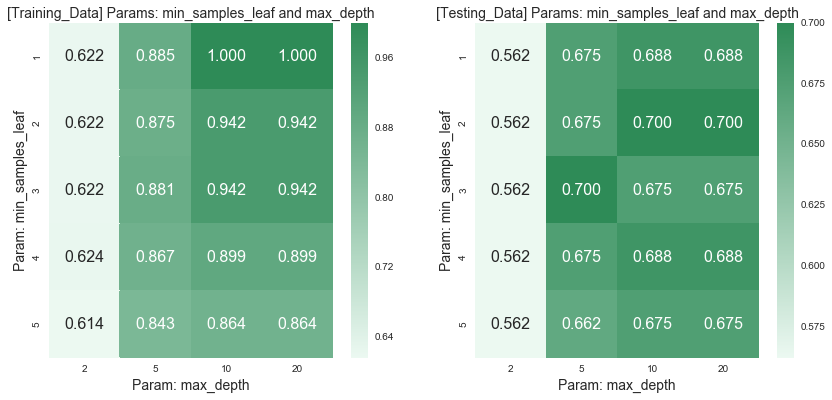

In [172]:
train_test_param_map(x_var_='max_depth', y_var_='min_samples_leaf', map_df_=map_df[map_df['criterion'] == 'entropy'])

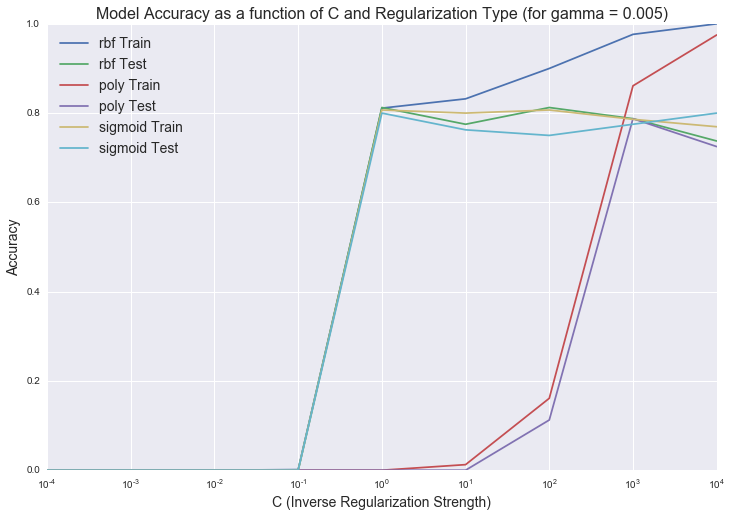

In [159]:
x_var = map_df[map_df['kernel'] == 'rbf']
x_var = x_var[x_var['gamma'] == 0.005]['C']
rbf = map_df[map_df['kernel'] == 'rbf']
rbf = rbf[rbf['gamma'] == 0.005]
poly = map_df[map_df['kernel'] == 'poly']
poly = poly[poly['gamma'] == 0.005]
sigmoid = map_df[map_df['kernel'] == 'sigmoid']
sigmoid = sigmoid[sigmoid['gamma'] == 0.005]

fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(x_var, rbf['mean_train_score'], label='rbf Train')
ax.semilogx(x_var, rbf['mean_test_score'], label='rbf Test')
ax.semilogx(x_var, poly['mean_train_score'], label='poly Train')
ax.semilogx(x_var, poly['mean_test_score'], label='poly Test')
ax.semilogx(x_var, sigmoid['mean_train_score'], label='sigmoid Train')
ax.semilogx(x_var, sigmoid['mean_test_score'], label='sigmoid Test')
ax.legend(fontsize=14, loc='best')
ax.set_title('Model Accuracy as a function of C and Regularization Type (for gamma = 0.005)', fontsize=16)
ax.set_xlabel('C (Inverse Regularization Strength)', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

In [160]:
print('Best accuracy: {:0.3f}%'.format(svm_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(svm_gs.best_params_))

Best accuracy: 81.250%
Best parameter(s): {'svm__C': 1, 'svm__gamma': 0.005, 'svm__kernel': 'rbf'}


The confusion matrices below used a **Support Vector Classifier** with parameters {$C = 1.0$, kernel $= \text{rbf}$, and $\gamma = 0.005$}, used normalized data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.17$ unhealthy people as being healthy, which is slightly worse than the best logistic regression classifier above, although this model labeled $2.93$ healthy people as unhealthy which is slightly better than the best logistic regression model.

Considering the differing costs of mistakes, this is a not an improvement on our best model.

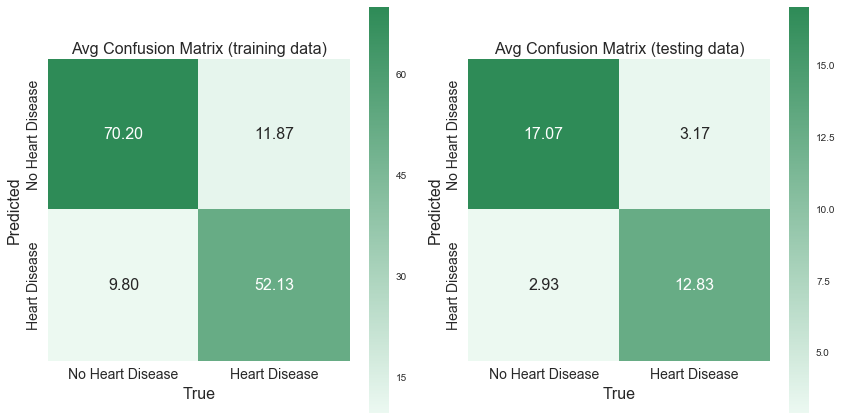

In [162]:
cross_validated_cm_generator(clf_=svm_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])